<a href="https://colab.research.google.com/github/jai2shan/TSAI-EVA40-Assignments/blob/master/Session%2010/Assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !git clone https://github.com/jai2shan/TSAI-EVA40-Assignments.git
import os
os.chdir(r'/content/TSAI-EVA40-Assignments/Session 10/asgnmt10')

In [2]:
from torchvision import transforms
from DataLoader import cifar_data_loader,View_images
from cutout import *
import torch
from torchsummary import summary
from resnet import ResNet18

from LR_Finder import *
from Training_Testing import TrainTest
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from ModelPerformance import *
from gradcam import GradCamDisplay
import PIL
from gradcam import *
import copy
import pandas as pd

In [3]:
trainloader,testloader = cifar_data_loader(BatchSize=250)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

net = ResNet18().to(device)
summary(net, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,


Learning rate search finished. See the graph with {finder_name}.plot()


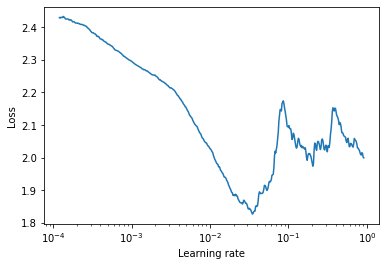

ValueError: ignored

In [5]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

lr_finder = LRFinder(net, optimizer, criterion)
lr_finder.range_test(trainloader, end_lr=1, num_iter=500,step_mode="exp")
lr_finder.plot()


In [6]:
lr_ = pd.DataFrame(lr_finder.history)
lr_max = lr_.loc[lr_['loss']==lr_['loss'].min(),'lr'].values[0]

In [7]:
tt = TrainTest()
test_acc = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr_max, momentum=0.9,weight_decay = 0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

for epoch in range(50):
    print("EPOCH:", epoch)
    tt.train_(net, device, trainloader, optimizer, criterion, epoch,L1 = False)
    acc = tt.test_(net, device, testloader)  
    scheduler.step(tt.test_losses[epoch])
       
print('Finished Training')

  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH: 0


Loss=1.3234590291976929 Batch_id=199 Accuracy=45.00: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -3.6976, Accuracy: 5512/10000 (55.12%)

EPOCH: 1


Loss=1.169706106185913 Batch_id=199 Accuracy=55.25: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -4.5574, Accuracy: 6503/10000 (65.03%)

EPOCH: 2


Loss=1.0138779878616333 Batch_id=199 Accuracy=61.93: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.2567, Accuracy: 6732/10000 (67.32%)

EPOCH: 3


Loss=0.8527284860610962 Batch_id=199 Accuracy=66.45: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -5.7255, Accuracy: 7407/10000 (74.07%)

EPOCH: 4


Loss=0.8209312558174133 Batch_id=199 Accuracy=69.33: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.7327, Accuracy: 7621/10000 (76.21%)

EPOCH: 5


Loss=0.6869062185287476 Batch_id=199 Accuracy=71.63: 100%|██████████| 200/200 [00:37<00:00,  5.34it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.4667, Accuracy: 7901/10000 (79.01%)

EPOCH: 6


Loss=0.7951552271842957 Batch_id=199 Accuracy=73.42: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.1625, Accuracy: 7927/10000 (79.27%)

EPOCH: 7


Loss=0.7171977758407593 Batch_id=199 Accuracy=74.75: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -6.8825, Accuracy: 7812/10000 (78.12%)

EPOCH: 8


Loss=0.7371516227722168 Batch_id=199 Accuracy=75.93: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.3681, Accuracy: 8118/10000 (81.18%)

EPOCH: 9


Loss=0.6967602968215942 Batch_id=199 Accuracy=76.82: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -7.0596, Accuracy: 8137/10000 (81.37%)

EPOCH: 10


Loss=0.6150650382041931 Batch_id=199 Accuracy=78.04: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.6232, Accuracy: 8267/10000 (82.67%)

EPOCH: 11


Loss=0.5704807043075562 Batch_id=199 Accuracy=78.68: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.4587, Accuracy: 8481/10000 (84.81%)

EPOCH: 12


Loss=0.7292084097862244 Batch_id=199 Accuracy=79.45: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.3916, Accuracy: 8400/10000 (84.00%)

EPOCH: 13


Loss=0.5094534754753113 Batch_id=199 Accuracy=80.31: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.6340, Accuracy: 8404/10000 (84.04%)

EPOCH: 14


Loss=0.618452250957489 Batch_id=199 Accuracy=80.91: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.3143, Accuracy: 8524/10000 (85.24%)

EPOCH: 15


Loss=0.6429123878479004 Batch_id=199 Accuracy=81.16: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.1425, Accuracy: 8365/10000 (83.65%)

EPOCH: 16


Loss=0.4957628846168518 Batch_id=199 Accuracy=81.78: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.9274, Accuracy: 8634/10000 (86.34%)

EPOCH: 17


Loss=0.5558123588562012 Batch_id=199 Accuracy=82.42: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.1334, Accuracy: 8556/10000 (85.56%)

EPOCH: 18


Loss=0.4251716136932373 Batch_id=199 Accuracy=82.72: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.3089, Accuracy: 8698/10000 (86.98%)

EPOCH: 19


Loss=0.5548603534698486 Batch_id=199 Accuracy=83.43: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.2830, Accuracy: 8549/10000 (85.49%)

EPOCH: 20


Loss=0.5462309122085571 Batch_id=199 Accuracy=83.57: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4371, Accuracy: 8674/10000 (86.74%)

EPOCH: 21


Loss=0.48262038826942444 Batch_id=199 Accuracy=83.67: 100%|██████████| 200/200 [00:37<00:00,  5.36it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -8.8577, Accuracy: 8814/10000 (88.14%)

EPOCH: 22


Loss=0.5458105802536011 Batch_id=199 Accuracy=84.39: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4042, Accuracy: 8824/10000 (88.24%)

EPOCH: 23


Loss=0.4225488007068634 Batch_id=199 Accuracy=84.58: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.1300, Accuracy: 8736/10000 (87.36%)

EPOCH: 24


Loss=0.44586920738220215 Batch_id=199 Accuracy=84.97: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5163, Accuracy: 8873/10000 (88.73%)

EPOCH: 25


Loss=0.4541319012641907 Batch_id=199 Accuracy=85.07: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.0509, Accuracy: 8841/10000 (88.41%)

EPOCH: 26


Loss=0.4342093765735626 Batch_id=199 Accuracy=85.25: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.2219, Accuracy: 8799/10000 (87.99%)

EPOCH: 27


Loss=0.43107274174690247 Batch_id=199 Accuracy=85.58: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5202, Accuracy: 8731/10000 (87.31%)

EPOCH: 28


Loss=0.41673263907432556 Batch_id=199 Accuracy=85.77: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.7866, Accuracy: 8935/10000 (89.35%)

EPOCH: 29


Loss=0.46708762645721436 Batch_id=199 Accuracy=86.16: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.3579, Accuracy: 8747/10000 (87.47%)

EPOCH: 30


Loss=0.5323030948638916 Batch_id=199 Accuracy=86.09: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4250, Accuracy: 8988/10000 (89.88%)

EPOCH: 31


Loss=0.4054356813430786 Batch_id=199 Accuracy=86.42: 100%|██████████| 200/200 [00:37<00:00,  5.34it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.2622, Accuracy: 8776/10000 (87.76%)

EPOCH: 32


Loss=0.3775598704814911 Batch_id=199 Accuracy=86.75: 100%|██████████| 200/200 [00:37<00:00,  5.32it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5199, Accuracy: 8874/10000 (88.74%)

EPOCH: 33


Loss=0.410978764295578 Batch_id=199 Accuracy=87.08: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.9470, Accuracy: 9007/10000 (90.07%)

EPOCH: 34


Loss=0.39436325430870056 Batch_id=199 Accuracy=87.14: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.9128, Accuracy: 8873/10000 (88.73%)

EPOCH: 35


Loss=0.38672226667404175 Batch_id=199 Accuracy=86.97: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5356, Accuracy: 8880/10000 (88.80%)

EPOCH: 36


Loss=0.40048038959503174 Batch_id=199 Accuracy=87.50: 100%|██████████| 200/200 [00:37<00:00,  5.38it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4976, Accuracy: 8843/10000 (88.43%)

EPOCH: 37


Loss=0.37503382563591003 Batch_id=199 Accuracy=87.48: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4392, Accuracy: 8880/10000 (88.80%)

EPOCH: 38


Loss=0.25804442167282104 Batch_id=199 Accuracy=87.71: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.6835, Accuracy: 8941/10000 (89.41%)

EPOCH: 39


Loss=0.39907437562942505 Batch_id=199 Accuracy=87.65: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.3276, Accuracy: 8736/10000 (87.36%)

EPOCH: 40


Loss=0.42910200357437134 Batch_id=199 Accuracy=87.76: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4335, Accuracy: 8974/10000 (89.74%)

EPOCH: 41


Loss=0.33654651045799255 Batch_id=199 Accuracy=88.16: 100%|██████████| 200/200 [00:36<00:00,  5.41it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.0830, Accuracy: 8824/10000 (88.24%)

EPOCH: 42


Loss=0.38986217975616455 Batch_id=199 Accuracy=87.83: 100%|██████████| 200/200 [00:37<00:00,  5.34it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.5311, Accuracy: 8949/10000 (89.49%)

EPOCH: 43


Loss=0.40384259819984436 Batch_id=199 Accuracy=88.20: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.4138, Accuracy: 8966/10000 (89.66%)

EPOCH: 44


Loss=0.3525106906890869 Batch_id=199 Accuracy=88.32: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.2817, Accuracy: 8818/10000 (88.18%)

Epoch    45: reducing learning rate of group 0 to 3.4760e-03.
EPOCH: 45


Loss=0.18426509201526642 Batch_id=199 Accuracy=91.59: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.0016, Accuracy: 9238/10000 (92.38%)

EPOCH: 46


Loss=0.18093819916248322 Batch_id=199 Accuracy=92.80: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -9.9846, Accuracy: 9271/10000 (92.71%)

EPOCH: 47


Loss=0.1820899248123169 Batch_id=199 Accuracy=93.22: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.1172, Accuracy: 9272/10000 (92.72%)

EPOCH: 48


Loss=0.22479046881198883 Batch_id=199 Accuracy=93.49: 100%|██████████| 200/200 [00:37<00:00,  5.39it/s]
  0%|          | 0/200 [00:00<?, ?it/s]


Test set: Average loss: -10.1458, Accuracy: 9281/10000 (92.81%)

EPOCH: 49


Loss=0.22540953755378723 Batch_id=199 Accuracy=93.80: 100%|██████████| 200/200 [00:37<00:00,  5.37it/s]



Test set: Average loss: -10.2261, Accuracy: 9298/10000 (92.98%)

Finished Training


In [ ]:
PlotTrainingGraphs(tt)

In [ ]:
Misclassification(testloader,net,classes,device)

In [ ]:
from gradcam import GradCamDisplay
import PIL
img_name =['airplane.png','automobile.png','bird.png','cat.png','deer.png']

pil_image = []
for i,img in enumerate(img_name):
   pil_image.append(PIL.Image.open(img))

In [ ]:
from pylab import *
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4],padding=1))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
images[:4]